In [1]:
import torch
from torch.utils.data import dataset,dataloader
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
from torchvision.models import Inception_V3_Weights
weights = Inception_V3_Weights.DEFAULT
ans = torch.topk(prediction,1)[1][0][0]
print(ans)
print(weights.meta['categories'][ans])

In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision as tv

class LSUNCars(Dataset):
    def __init__(self, imdir, transform=None):
        """
        Args:
            imdir (str): Path to the directory with images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.imdir = imdir
        # List only jpg and png files; adjust if needed.
        self.filenames = [os.path.join(imdir, fname) 
                          for fname in os.listdir(imdir) 
                          if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"Found {len(self.filenames)} images in {imdir}")  # Debugging line
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        # Open image and ensure it's RGB
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        image = tv.transforms.ToTensor()(image)
        return image

# Define any transforms you need (e.g., resizing and conversion to tensor)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Path to your image directory
imdir = '../dataset/cars_train/cars_train'

# Create dataset instance
dataset = LSUNCars(imdir, transform=None)

# Create DataLoader to iterate over the dataset
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

Found 8144 images in ../dataset/cars_train/cars_train


In [2]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def closest_color(rgb_color, colors):
    # colors: dict mapping color name -> RGB tuple
    distances = {name: np.linalg.norm(np.array(rgb_color) - np.array(rgb_val))
                 for name, rgb_val in colors.items()}
    return min(distances, key=distances.get)

# Define some common colors (for cars, you might add more as needed)
target_colors = {
    'red': (255, 0, 0),
    'green': (0, 255, 0),
    'blue': (0, 0, 255),
    'black': (0, 0, 0),
    'white': (255, 255, 255),
    'silver': (192, 192, 192),
    'gray': (128, 128, 128),
    'yellow': (255, 255, 0),
    'orange': (255, 165, 0),
    'brown': (165, 42, 42),
    'gold': (255, 215, 0),
    'beige': (245, 245, 220),
    'purple': (128, 0, 128),
    'pink': (255, 192, 203),
    'teal': (0, 128, 128),
    'maroon': (128, 0, 0)
}


def extract_dominant_colors(image, n_clusters=5):
    # Load image using OpenCV (BGR) and convert to RGB
    # image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Reshape the image to be a list of pixels
    pixels = image.reshape((-1, 3))
    
    # Use KMeans to find clusters in the pixel data
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pixels)
    cluster_centers = kmeans.cluster_centers_.astype(int)
    print(cluster_centers)
    labels = kmeans.labels_
    
    # Count the number of pixels in each cluster
    counts = np.bincount(labels)
    
    # Map each cluster center to the closest target color
    color_results = {}
    for i, center in enumerate(cluster_centers):
        # Find the nearest target color name
        color_name = closest_color(center, target_colors)
        # Sum counts if multiple clusters map to the same common color
        color_results[color_name] = color_results.get(color_name, 0) + counts[i]
    
    # Find the overall dominant common color
    dominant_color = max(color_results, key=color_results.get)
    
    return dominant_color, color_results, cluster_centers, counts

In [3]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the pretrained Inception v3 model
model = models.inception_v3(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Disable auxiliary logits for inference
model.aux_logits = False
model.eval()  # set model to evaluation mode

# Define the preprocessing transforms.
# Inception v3 expects 299x299 input images.
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

/home/project/anaconda3/envs/latentconst/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/project/anaconda3/envs/latentconst/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
from scipy.io import loadmat
from torchvision.models import Inception_V3_Weights
weights = Inception_V3_Weights.DEFAULT


# Load the .mat file
data = loadmat('../dataset/car_devkit/devkit/cars_train_annos.mat')


img_dir = '../dataset/cars_train/cars_train'
filenames = [os.path.join(imdir, fname) 
                          for fname in os.listdir(imdir) 
                          if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

# indices = np.random.randint(0,len(filenames),64)
# print(filenames)

X = []
Y = {}
dominant_colors = []
results = []
centres = []
counts = []
for i in range(10050):
    # Open the image using PIL
    try :
        image = Image.open(filenames[i])
        
        # Extract the index and annotation values (adjust this to your data format)
        index = int(filenames[i].split('/')[-1].split('.')[0])
        annot = data['annotations'][0][index-1]
        x1 = int(annot[0][0])
        y1 = int(annot[1][0])
        x2 = int(annot[2][0])
        y2 = int(annot[3][0])
        
        cropped_img = image.crop((x1, y1, x2, y2))
        
        # This section aims to find the images from teh dataset that have same label assigned by inception v3
        input_tensor = preprocess(image).to(device).unsqueeze(0)
        prediction = model(input_tensor).detach()
        
        ans = torch.topk(prediction,1)[1][0][0]
        # print(ans)
        # print(weights.meta['categories'][ans])
        
        if ans == 817:
            name = filenames[i].split('/')[-1]
            cropped_img.save(f'../dataset/sports_car/{name}')
    except Exception as e:
        print(e)
    
    
    
    
    
    # X.append(cropped_img)

/tmp/ipykernel_1421176/4268791659.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = int(annot[0][0])
/tmp/ipykernel_1421176/4268791659.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int(annot[1][0])
/tmp/ipykernel_1421176/4268791659.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = int(annot[2][0])
/tmp/ipykernel_1421176/4268791659.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in

output with shape [1, 299, 299] doesn't match the broadcast shape [3, 299, 299]
output with shape [1, 299, 299] doesn't match the broadcast shape [3, 299, 299]
output with shape [1, 299, 299] doesn't match the broadcast shape [3, 299, 299]
output with shape [1, 299, 299] doesn't match the broadcast shape [3, 299, 299]
output with shape [1, 299, 299] doesn't match the broadcast shape [3, 299, 299]
output with shape [1, 299, 299] doesn't match the broadcast shape [3, 299, 299]
output with shape [1, 299, 299] doesn't match the broadcast shape [3, 299, 299]
output with shape [1, 299, 299] doesn't match the broadcast shape [3, 299, 299]
output with shape [1, 299, 299] doesn't match the broadcast shape [3, 299, 299]
output with shape [1, 299, 299] doesn't match the broadcast shape [3, 299, 299]
output with shape [1, 299, 299] doesn't match the broadcast shape [3, 299, 299]
output with shape [1, 299, 299] doesn't match the broadcast shape [3, 299, 299]
output with shape [1, 299, 299] doesn't 

In [4]:

def layer_activation(model, input_tensor, layer_name):
    model.eval() 
    activations = {}

    def get_activation(name):
        def hook(module, input, output):
            activations[name] = output.detach()
        return hook

    target_module = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_module = module
            break

    if target_module is None:
        raise ValueError(f"Layer '{layer_name}' not found in the model.")

    target_module.register_forward_hook(get_activation(layer_name))
    _ = model(input_tensor)
    
    return activations[layer_name]


import matplotlib.pyplot as plt

def plot_activation_maps(activation, cols=5, cmap='gray', figsize=(20, 20)):
    """
    Plots activation maps in a grid.
    
    Parameters:
        activation (Tensor): Tensor of shape [N, H, W] containing activation maps.
        cols (int): Number of columns in the grid.
        cmap (str): Color map to use for plotting.
        figsize (tuple): Figure size.
    """
    # Remove extra dimensions if any (e.g., batch dim of 1)
    activation = activation.squeeze()
    
    # Number of activation maps
    num_maps = activation.shape[0]
    
    # Compute rows required (add one extra row if necessary)
    rows = num_maps // cols + (num_maps % cols > 0)
    
    # Create a grid of subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    # Flatten axes array for easier indexing (if rows>1)
    axes = axes.flatten() if num_maps > 1 else [axes]
    
    # Plot each activation map
    for i in range(num_maps):
        # Convert to numpy array (detach if needed)
        axes[i].imshow(activation[i].detach().cpu().numpy(), cmap=cmap)
        axes[i].axis('off')
    
    # Hide any unused subplots
    for j in range(num_maps, len(axes)):
        axes[j].axis('off')
    
    # plt.tight_layout()
    plt.show()



In [5]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load the pretrained Inception v3 model
model = models.inception_v3(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Disable auxiliary logits for inference
model.aux_logits = False
model.eval()  # set model to evaluation mode

# Define the preprocessing transforms.
# Inception v3 expects 299x299 input images.
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load an image
img = X[11]
# print(np.array(img).shape)
# plt.imshow(np.array(img))
# plt.show()

input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)
input_batch = input_batch.to(device)

# # Perform inference without tracking gradients
# with torch.no_grad():
#     output = model(input_batch)
#     # If output is a tuple (Inception returns a namedtuple during training), use output.logits
#     if isinstance(output, (tuple, list)):
#         output = output[0]
#     # Convert output logits to probabilities
#     probabilities = torch.nn.functional.softmax(output, dim=1)

# # Get the top 5 predictions
# top5_prob, top5_catid = torch.topk(probabilities, 1)
# print("Top-5 probabilities:", top5_prob)
# print("Top-5 categories indices:", top5_catid)


/home/project/anaconda3/envs/latentconst/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/project/anaconda3/envs/latentconst/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


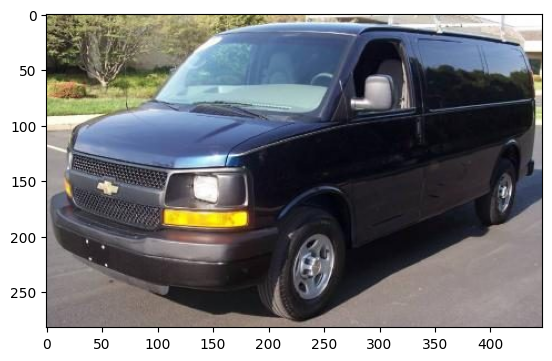

In [6]:
img = X[11]
# print(np.array(img).shape)
plt.imshow(np.array(img))
plt.show()

input_tensor = preprocess(img).to(device).unsqueeze(0)
# input_batch = input_tensor.unsqueeze(0)
# input_batch = input_batch.to(device)

torch.Size([2048, 8, 8])
torch.Size([1, 8, 8])


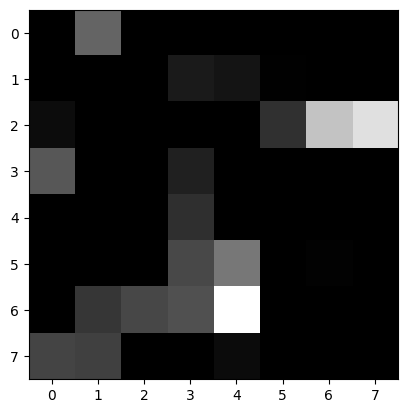

In [7]:
conv1a = layer_activation(model,input_tensor,'Mixed_7c')
conv1a = conv1a.squeeze()
print(conv1a.shape)
print(conv1a[100].unsqueeze(0).shape)
plt.imshow(conv1a[0].detach().cpu(),cmap = 'gray')
plt.show()

In [8]:
plot_activation_maps(conv1a,cols=1)

KeyboardInterrupt: 

In [9]:
import torch.nn.functional as F

def gram_matrix(features):
    # features shape: [batch, channels, height, width]
    (b, c, h, w) = features.size()
    features = features.view(b, c, h * w)
    gram = torch.bmm(features, features.transpose(1, 2))
    return gram / (c * h * w)

def style_loss(gram_style, gram_target):
    return torch.tensor(F.mse_loss(gram_target, gram_style)).to(device)

def content_loss(content_target, content_generated):
    return torch.tensor(F.mse_loss(content_generated, content_target)).to(device)

In [10]:
style_tensor = preprocess(X[0]).to(device).unsqueeze(0)
target_tensor = preprocess(X[2]).to(device).unsqueeze(0)

selected_layers = ['Conv2d_1a_3x3', 'Mixed_5b', 'Mixed_7c']
style_features = []
target_features = []


for layer in selected_layers:
    style_features.append(layer_activation(model,style_tensor,layer))
    target_features.append(layer_activation(model,target_tensor,layer))


style_loss_total = 0
for layer in range(len(selected_layers)):
    gram_style = gram_matrix(style_features[layer])
    gram_target = gram_matrix(target_features[layer])
    style_loss_total += F.mse_loss(gram_target, gram_style)
    

contentloss = content_loss(style_tensor,target_tensor)
# print("Total style loss:", style_loss_total.item())   
# print("Content Loss" , contentloss)


total_loss = content_loss + style_loss 

/tmp/ipykernel_1114111/2818736728.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(F.mse_loss(content_generated, content_target)).to(device)


TypeError: unsupported operand type(s) for +: 'function' and 'function'

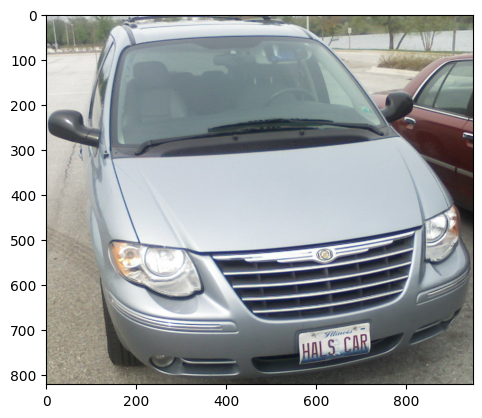

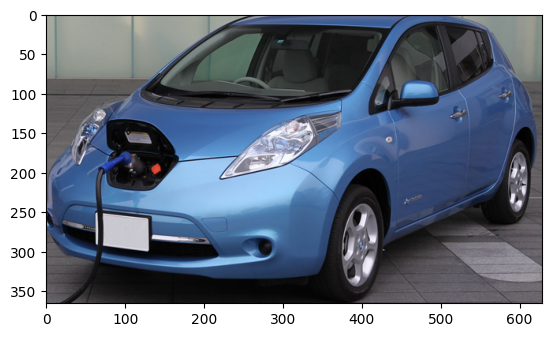

In [11]:
plt.imshow(X[0])
plt.show()
plt.imshow(X[20])
plt.show()

In [ ]:
from torchvision.models import Inception_V3_Weights
weights = Inception_V3_Weights.DEFAULT

for i in top5_catid[0]:
    # Print the list of categories (ImageNet classes)
    print(weights.meta['categories'][i])


NameError: name 'top5_catid' is not defined

In [12]:
from torchsummary import summary

# For Inception v3, input shape should be (3, 299, 299)
print(summary(model, (3, 299, 299)))


Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 32, 149, 149]        --
|    └─Conv2d: 2-1                       [-1, 32, 149, 149]        864
|    └─BatchNorm2d: 2-2                  [-1, 32, 149, 149]        64
├─BasicConv2d: 1-2                       [-1, 32, 147, 147]        --
|    └─Conv2d: 2-3                       [-1, 32, 147, 147]        9,216
|    └─BatchNorm2d: 2-4                  [-1, 32, 147, 147]        64
├─BasicConv2d: 1-3                       [-1, 64, 147, 147]        --
|    └─Conv2d: 2-5                       [-1, 64, 147, 147]        18,432
|    └─BatchNorm2d: 2-6                  [-1, 64, 147, 147]        128
├─MaxPool2d: 1-4                         [-1, 64, 73, 73]          --
├─BasicConv2d: 1-5                       [-1, 80, 73, 73]          --
|    └─Conv2d: 2-7                       [-1, 80, 73, 73]          5,120
|    └─BatchNorm2d: 2-8                  [-1, 80, 73, 73]          160
├─

In [13]:
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [14]:
# incepLayers = dict()


for name, module in model.named_modules():
    # print(name, module)
    pass
    # incepLayers[name] = module

In [15]:
for name, module in model.named_children():
    # print(name, module)/
    pass


In [16]:
img = Image.open('../styleGanImages/image_0017.png')

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

# img = preprocess(img)
# img.shape

# plt.imshow(img.permute(1,2,0))
# plt.show()

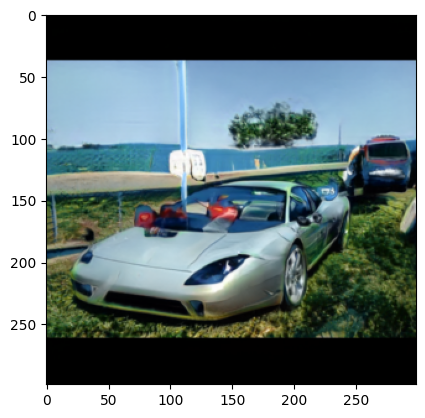

In [17]:
input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)
input_batch = input_batch.to(device)
prediction = model(input_batch)

img = preprocess(img)
img.shape

plt.imshow(img.permute(1,2,0))
plt.show()

In [18]:
from torchvision.models import Inception_V3_Weights
weights = Inception_V3_Weights.DEFAULT
ans = torch.topk(prediction,1)[1][0][0]
print(ans)
print(weights.meta['categories'][ans])

tensor(817, device='cuda:0')
sports car


In [19]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_dim=512, output_dim=512):
        super(Generator, self).__init__()
        # Define a simple network: one hidden layer with 1024 units and ReLU activation.
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, output_dim)
        )
    
    def forward(self, x):
        return self.model(x)

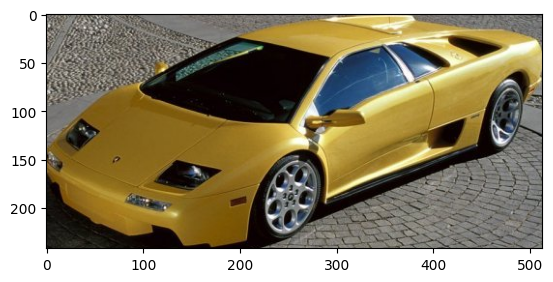

In [20]:
target_image = X[21]
plt.imshow(target_image)
plt.show()

In [21]:
target_tensor = preprocess(target_image).unsqueeze(0).to(device)
prediction = torch.topk(model(target_tensor),1)[1]
print(prediction)
print(weights.meta['categories'][prediction.unsqueeze(0)[0][0]])

# target_style = style

tensor([[817]], device='cuda:0')
sports car


In [22]:
import os
import torch
from torchvision.utils import save_image
import dnnlib
import legacy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained StyleGAN2 generator for cars
network_pkl = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-car-config-e.pkl"
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)


In [23]:
genrator_model = Generator(512,512).to(device)
z_inp = torch.randn([1,512]).to(device)
z_sample = genrator_model(z_inp)


In [3]:
from scipy.io import loadmat
from PIL import Image
import os

# Load the .mat file
data = loadmat('../dataset/car_devkit/devkit/cars_train_annos.mat')


img_dir = '../dataset/cars_train/cars_train'
filenames = [os.path.join(img_dir, fname) 
                          for fname in os.listdir(img_dir) 
                          if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

# indices = np.random.randint(0,len(filenames),64)
# print(filenames)

X = []
Y = {}
dominant_colors = []
results = []
centres = []
counts = []
for i in range(64):
    # Open the image using PIL
    image = Image.open(filenames[i])

    # Extract the index and annotation values (adjust this to your data format)
    index = int(filenames[i].split('/')[-1].split('.')[0])
    annot = data['annotations'][0][index-1]
    x1 = int(annot[0][0])
    y1 = int(annot[1][0])
    x2 = int(annot[2][0])
    y2 = int(annot[3][0])

    # Crop the image using PIL's crop method.
    # Note: PIL's crop expects (left, upper, right, lower)
    cropped_img = image.crop((x1, y1, x2, y2))
    
    # Append the resulting NumPy array to your list
    X.append(cropped_img)

/tmp/ipykernel_1988711/360438095.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = int(annot[0][0])
/tmp/ipykernel_1988711/360438095.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int(annot[1][0])
/tmp/ipykernel_1988711/360438095.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = int(annot[2][0])
/tmp/ipykernel_1988711/360438095.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in fut

/home/project/anaconda3/envs/latentconst/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/project/anaconda3/envs/latentconst/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


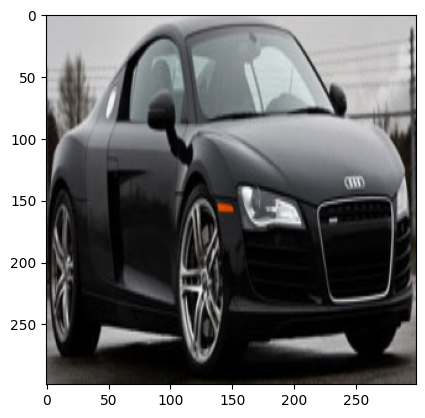

Step 0: Total Loss = 0.4272190034389496, Style Loss = 4.1930416045943275e-06, Content Loss = 0.00791484210640192


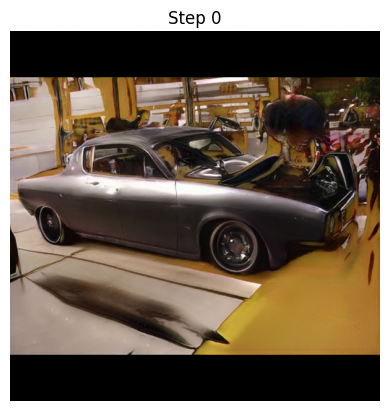

Step 100: Total Loss = 0.027949105948209763, Style Loss = 1.9881305490798695e-07, Content Loss = 0.008067800663411617


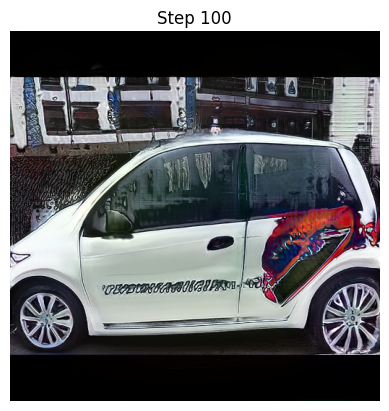

Step 200: Total Loss = 0.02461213618516922, Style Loss = 1.8049381367291062e-07, Content Loss = 0.006562754046171904


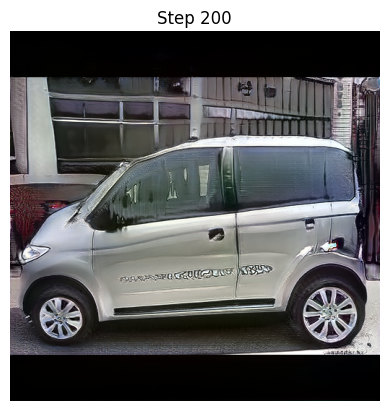

Step 300: Total Loss = 0.022373709827661514, Style Loss = 1.556440594185915e-07, Content Loss = 0.006809303071349859


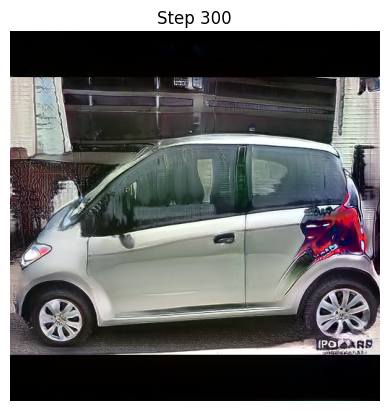

Step 400: Total Loss = 0.0217671450227499, Style Loss = 1.5288776467059506e-07, Content Loss = 0.006478368770331144


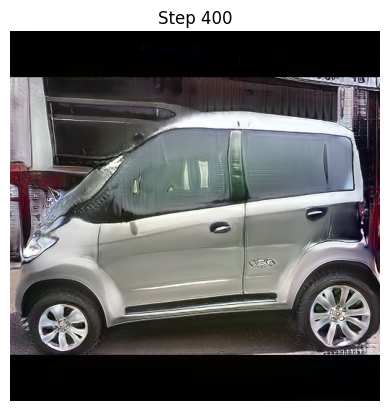

Step 500: Total Loss = 0.019608965143561363, Style Loss = 1.270711180723083e-07, Content Loss = 0.00690185371786356


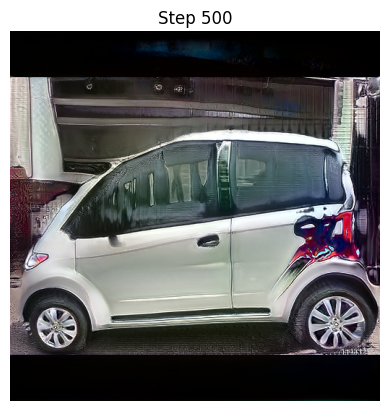

Step 600: Total Loss = 0.019283901900053024, Style Loss = 1.2590443532189965e-07, Content Loss = 0.006693457253277302


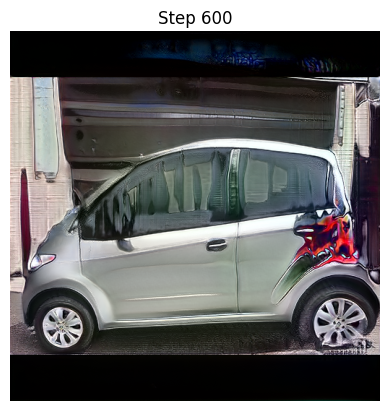

Step 700: Total Loss = 0.01953066885471344, Style Loss = 1.2469959642658068e-07, Content Loss = 0.007060709409415722


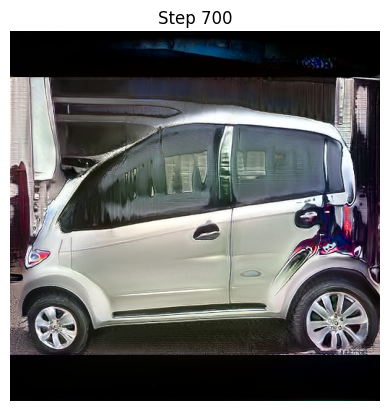

Step 800: Total Loss = 0.018594713881611824, Style Loss = 1.1738421790141729e-07, Content Loss = 0.006856292486190796


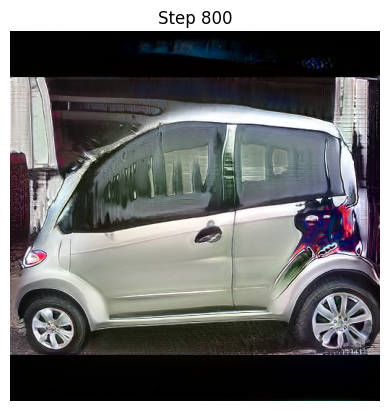

Step 900: Total Loss = 0.017588146030902863, Style Loss = 1.0686706986007266e-07, Content Loss = 0.0069014402106404305


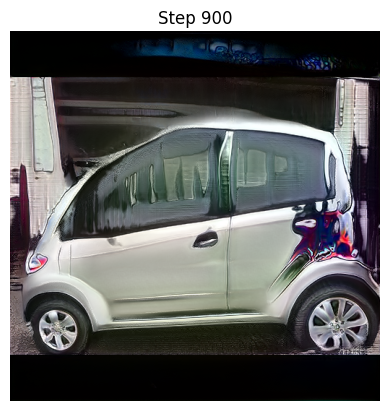

Step 1000: Total Loss = 0.018789010122418404, Style Loss = 1.1306484282158635e-07, Content Loss = 0.007482526358217001


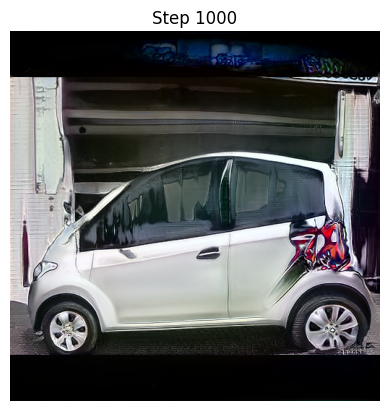

KeyboardInterrupt: 

In [6]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
import dnnlib
import legacy
from torchvision.utils import save_image
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

network_pkl = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-car-config-e.pkl"
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)
G.eval()
for param in G.parameters():
    param.requires_grad = False

inception = models.inception_v3(pretrained=True).to(device)
inception.eval()
for param in inception.parameters():
    param.requires_grad = False

class CustomLatentGenerator(nn.Module):
    def __init__(self, input_dim=512, output_dim=512):
        super(CustomLatentGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, output_dim)
        )
    def forward(self, x):
        return self.model(x)

custom_gen = CustomLatentGenerator().to(device)
# optimizer = optim.Adam(custom_gen.parameters(), lr=1e-3, weight_decay=1e-5)
optimizer = optim.Adam(custom_gen.parameters(), lr=1e-4)


preprocess1 = T.Compose([T.Resize((299, 299))])
preprocess = T.Compose([T.Resize((299,299)), T.ToTensor()])

def layer_activation(model, input_tensor, layer_name, detach_output=True):
    model.eval()
    activations = {}
    def get_activation(name):
        def hook(module, input, output):
            activations[name] = output if not detach_output else output.detach()
        return hook
    target_module = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_module = module
            break
    if target_module is None:
        raise ValueError(f"Layer '{layer_name}' not found in the model.")
    hook_handle = target_module.register_forward_hook(get_activation(layer_name))
    _ = model(input_tensor)
    hook_handle.remove()
    return activations[layer_name]

def gram_matrix(features):
    b, c, h, w = features.size()
    features = features.view(b, c, h * w)
    gram = torch.bmm(features, features.transpose(1, 2))
    return gram / (c * h * w)

def content_loss(content_target, content_generated):
    return F.mse_loss(content_generated, content_target)

selected_layers_style = ['Conv2d_1a_3x3', 'Mixed_5c', 'Mixed_6e']

selected_layers_content = ['Conv2d_1a_3x3', 'Mixed_5c', 'Mixed_6e']


# target_image = X[22]

target_tensor = preprocess(X[33]).unsqueeze(0).to(device)
plt.imshow(target_tensor.cpu().squeeze().permute(1,2,0))
plt.show()

style_features_target = []
content_features_target = []
for layer in selected_layers_style:
    style_features_target.append(layer_activation(inception, target_tensor, layer))
  
for layer in selected_layers_content:  
    content_features_target.append(layer_activation(inception, target_tensor, layer))

num_steps = 10000
for step in range(num_steps):
    optimizer.zero_grad()
    
    z = torch.randn([1, 512]).to(device)
    z_mod = custom_gen(z)
    
    w = G.mapping(z_mod, None)
    
    img = G.synthesis(w, noise_mode='const')
    img = (img.clamp(-1, 1) + 1) / 2
    img_inp = preprocess1(img.squeeze(0)).unsqueeze(0)
    
    
    style_features_gen = []
    content_features_gen = []
    for layer in selected_layers_style:
        feat = layer_activation(inception, img_inp, layer, detach_output=False)
        style_features_gen.append(feat)
        
    for layer in selected_layers_content:
        feat = layer_activation(inception, img_inp, layer, detach_output=False)
        content_features_gen.append(feat)
    
    
    style_loss_total = 0
    for gen_feat, target_feat in zip(style_features_gen, style_features_target):
        gram_gen = gram_matrix(gen_feat)
        gram_target = gram_matrix(target_feat)
        style_loss_total += F.mse_loss(gram_gen, gram_target)
        
        
    content_loss_val = content_loss(content_features_gen[0], content_features_target[0])
    # total_loss = 1e5*style_loss_total + content_loss_val
    total_loss = content_loss_val + 1e5* style_loss_total
    
    total_loss.backward()
    optimizer.step()
    
    if step % 100 == 0:
        torch.save(custom_gen.state_dict(), "custom_latent_generator.pth")
        print(f"Step {step}: Total Loss = {total_loss.item()}, Style Loss = {style_loss_total.item()}, Content Loss = {content_loss_val.item()}")
        plt.imshow(img.detach().cpu().squeeze().permute(1, 2, 0))
        plt.title(f"Step {step}")
        plt.axis('off')
        plt.show()


/tmp/ipykernel_1114111/1394735278.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_gen.load_state_dict(torch.load('custom_latent_generator.pth', map_location=devic

torch.Size([3, 299, 299])


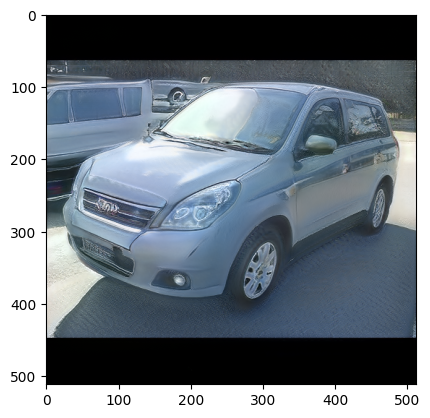

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_gen = CustomLatentGenerator().to(device)
custom_gen.load_state_dict(torch.load('custom_latent_generator.pth', map_location=device))
custom_gen.eval()


z = torch.randn([1, 512]).to(device)
z_mod = custom_gen(z)
    
w = G.mapping(z_mod, None)
img = G.synthesis(w, noise_mode='const')
img = (img.clamp(-1, 1) + 1) / 2

print(img_inp.squeeze().shape)
plt.imshow(img.detach().squeeze().cpu().permute(1,2,0))
plt.show()
